# Logistic Regression

In [1]:
import numpy as np
import pandas as pd
# Safe settings for Pandas.
pd.set_option('mode.chained_assignment', 'raise')
%matplotlib inline
import matplotlib.pyplot as plt
# Make the plots look more fancy.
plt.style.use('fivethirtyeight')
# Optimization function
from scipy.optimize import minimize

By Peter Rush and Matthew Brett, with considerable inspiration from the
logistic regression section of Allen Downey's book [Think Stats, second
edition](https://greenteapress.com/thinkstats2).

In this section we will look at another regression technique: logistic
regression.

We use logistic regression when we want to predict a *binary categorical*
outcome variable (or column) from one or more predicting variables (or
columns).

A binary categorical variable is one where an observation can fall into one of
only two categories. We give each observation a label corresponding to their
category.  Some examples are:

* Did a patient die or did they survive through 6 months of treatment?  The
  patient can only be in only one of the categories.  In some column of our
  data table, patients that died might have the label "died", and those who
  have survived have the label "survived".
* Did a person experience more than one episode of psychosis in the last 5
  years ("yes" or "no")?
* Did a person with a conviction for one offense offend again ("yes" or "no")?

For this tutorial, we return to the [chronic kidney disease
dataset](../data/chronic_kidney_disease).

Each row in this dataset represents one patient.

For each patient, the doctors recorded whether or not the patient had chronic
kidney disease. This is a *binary categorical variable*; you can see the
values in the "Class" column. A value of 1 means the patient *did* have CKD; a
value of 0 means they *did not*.  In this case we are labeling the categories
with numbers (1 / 0).

Many of the rest of the columns are measurements from blood tests and urine tests.

In [2]:
df = pd.read_csv('ckd_clean.csv')
df.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
1,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,1
2,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,1
3,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,1
4,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,1


There are actually a large number of binary categorical variables in this
dataset.   For example, the "Hypertension" column has labels for the two
categories "yes" (the patient had persistently high blood pressure) or "no".

The categorical variable we are interested in here is "Appetite".  This has
the label "good" for patients with good appetite, and "poor" for those with
poor appetite.  Poor appetite is a [symptom of chronic kidney
disease](https://www.sciencedirect.com/science/article/abs/pii/S0270929508001666).  In our case, we wonder whether the extent of kidney damage does a convincing job in predicting whether the patient has a "good" appetite.

As you remember, the CKD dataset has a column "Hemoglobin" that has the
concentration of hemoglobin from a blood sample.  Hemoglobin is the molecule
that carries oxygen in the blood; it is the molecule that makes the red blood
cells red.  Damaged kidneys produce lower concentrations of the hormone that
stimulates red blood cell production,
[erythropoietin](https://en.wikipedia.org/wiki/Erythropoietin), so CKD
patients often have fewer red blood cells, and lower concentrations of
Hemoglobin.  We will take lower "Hemoglobin" as a index of kidney damage.
Therefore, we predict that patients with lower "Hemoglobin" values are more
likely to have `poor` "Appetite" values, and, conversely, patients with higher
"Hemoglobin" values are more likely to have `good` "Appetite" values.

First we make a new data frame that just has the two columns we are interested
in:

In [3]:
hgb_app = df.loc[:, ['Hemoglobin', 'Appetite']].copy()
hgb_app.head()

,Hemoglobin,Appetite
0,11.2,poor
1,9.5,poor
2,10.8,poor
3,5.6,poor
4,7.7,poor


## Dummy Variables

We will soon find ourselves wanting to do calculations on the values in the
"Appetite" column, and we cannot easily do that with the current string values
of "good" and "poor".   Our next step is to recode the string values to
numbers, ready for our calculations.  We use 1 to represent "good" and 0 to
represent "poor".  This kind of recoding, where we replace category labels
with 1 and 0 values, is often called *dummy coding*.

In [4]:
# Make a Boolean Series (True, False)
good_appetite = hgb_app['Appetite'] == 'good'
# Convert to an integer (1 for True, 0 for False), and store.
hgb_app['appetite_dummy'] = good_appetite.astype(int)
hgb_app.head()

,Hemoglobin,Appetite,appetite_dummy
0,11.2,poor,0
1,9.5,poor,0
2,10.8,poor,0
3,5.6,poor,0
4,7.7,poor,0


*Note*: When you are doing this, be sure to keep track of which label you have
coded as 1. Normally this would be the more interesting outcome.  In this
case, "good" has the code 1. Keep track of the label corresponding to 1, as it
will affect the interpretation of the regression coefficients.

Now we have the dummy (1 or 0) variable, let us use a scatter plot to look at
the relationship between hemoglobin concentration and whether a patient has a
good appetite.

Before we do this, it is convenient to add another column to color the "good" and "poor" appetite points:

In [5]:
hgb_app['appetite_color'] = 'red'
hgb_app.loc[good_appetite, 'appetite_color'] = 'blue'

Now we can plot the hemoglobin values on the x axis (our predictor) against
the appetite values on the y axis (the values to predict).

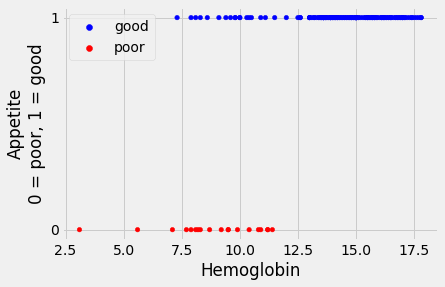

In [6]:
# We will use this plotting code several times, so put into a function for
# later use.

def plot_hgb_app():
    # Build plot, add custom label.
    hgb_app.plot.scatter('Hemoglobin', 'appetite_dummy',
                         c='appetite_color',
                         legend=True)
    plt.ylabel('Appetite\n0 = poor, 1 = good')
    plt.yticks([0,1]);  # Just label 0 and 1 on the y axis.
    # Put a custom legend on the plot.  This code is a little obscure.
    plt.scatter([], [], c='blue', label='good')
    plt.scatter([], [], c='red', label='poor')

# Do the plot
plot_hgb_app()
# Show the legend
plt.legend();

From the plot, it does look as if the patients with lower hemoglobin are more
likely to have poor appetite (`appetite_dummy` values of 0), whereas patients
with higher hemoglobin tend to have good appetite (`appetite_dummy` values of
1).

Now we start to get more formal, and develop a model with which we predict the
`appetite_dummy` values from the  `Hemoglobin` values.


## How about linear regression?

Remember that, in linear regression, we predict scores on the *outcome*
variable (or column) using a straight-line relationship of the *predictor*
variable (or column).

Why not use this same technique for our case?  After all, the `appetite_dummy`
values are just numbers (0 and 1), as are our `Hemoglobin` values.

Earlier in the textbook, we performed linear regression by using `minimize`, to
find the value of the slope and intercept of the line which gives the smallest
sum of the squared prediction errors.

Recall that, in linear regression:

$$
\text{predicted} = intercept + slope * \text{predictor_variable}
$$

*predicted* and *predictor variable* here are sequences of values, with one
value for each observation (row) in the dataset. In our case we have:

In [7]:
print('Rows in CKD data', len(hgb_app))

Rows in CKD data 158


"observations" (patients), so there will be the same number of scores on the
predictor variable (`Hemoglobin`), and the same number of predictions, in
`predicted`. By contrast, the slope and intercept are single values, defining
the line.

We used `minimize` to find the values of the slope and intercept which give the
"best" predictions.  So far, we have almost invariably defined the *best*
values for slope and intercept as the values that give the smallest sum of the
squared prediction errors.

$$
\text{prediction errors} = \text{actual variable - predicted}
$$

What would happen if we tried to use linear regression to predict the
probability of having good appetite, based on hemoglobin concentrations?

Let us start by grabbing the `ss_any_line` function from the [Using minimize
page](../mean-slopes/using_minimize.html).

In [8]:
def ss_any_line(c_s, x_values, y_values):
    # c_s is a list containing two elements, an intercept and a slope.
    intercept, slope = c_s
    # Values predicted from these x_values, using this intercept and slope.
    predicted = intercept + x_values * slope
    # Difference of prediction from the actual y values.
    error = y_values - predicted
    # Sum of squared error.
    return np.sum(error ** 2)

The sum of squared prediction error, in linear regression, is our *cost*
function. When we have a good pair of (intercept, slope) in `c_s`, our function
is *cheap* - i.e. the returned value is small.  When we have a bad pair in
`c_s`, our function is *expensive* - the returned value is large.

If the value from `ss_any_line` is large, it means the line we are fitting does
not fit the data well. The purpose of linear regression is to find the
line which leads to the smallest cost.  In our case, the cost is the sum of the
squared prediction errors.

Let's use linear regression on the current example.  From looking at our plot above, we start with a guess of -1 for the intercept, and 0.1 for the slope.

In [9]:
# The x (predictor) and y (to-be-predicted) variables.
hemoglobin = hgb_app['Hemoglobin']
appetite_d = hgb_app['appetite_dummy']
# Use minimize to find the least sum of squares solution.
min_lin_reg = minimize(ss_any_line, [-1, 0.1], args=(hemoglobin, appetite_d))
# Show the results that came back from minimize.
min_lin_reg

      fun: 10.315509522411862
 hess_inv: array([[ 0.07498683, -0.00524735],
       [-0.00524735,  0.00038337]])
      jac: array([-7.39097595e-06,  5.13792038e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 104
      nit: 2
     njev: 31
   status: 2
  success: False
        x: array([-0.07904187,  0.0700493 ])

OK, so that looks hopeful. Using linear regression with `minimize` we found that the sum of squared prediction errors was smallest for a line with:

In [10]:
# Unpack the slope and intercept estimates from the results object.
lin_reg_intercept, lin_reg_slope = min_lin_reg.x
# Show them.
print('Best linear regression intercept', lin_reg_intercept)
print('Best linear regression slope', lin_reg_slope)

Best linear regression intercept -0.07904187280281949
Best linear regression slope 0.07004929869481377


The linear regression model we are using here is:

```
predicted_appetite_d = intercept + slope * hemoglobin
```

Specifically:

In [11]:
predicted_lin_reg = lin_reg_intercept + lin_reg_slope * hemoglobin
predicted_lin_reg

0      0.705510
1      0.586426
2      0.677491
3      0.313234
4      0.460338
         ...   
153    1.020732
154    1.076772
155    1.027737
156    0.915658
157    1.027737
Name: Hemoglobin, Length: 158, dtype: float64

Let's plot our predictions, alongside the actual data.  We plot the predictions
from linear regression in orange.

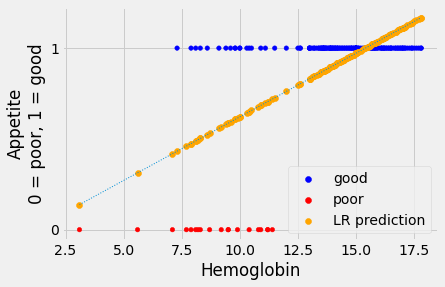

In [12]:
# Do the base plot of the hemoglobin and appetite_d.
plot_hgb_app()

# A new plot on top of the old.
plt.scatter(hemoglobin, predicted_lin_reg,
            label='LR prediction',
            color='orange')
# Another plot, to show the underlying line
fine_x = np.linspace(np.min(hemoglobin), np.max(hemoglobin), 1000)
fine_y = lin_reg_intercept + lin_reg_slope * fine_x
plt.plot(fine_x, fine_y, linewidth=1, linestyle=':')
# Show the legend.
plt.legend();

The linear regression line looks plausible, as far as it goes, but it has
several unhappy features for our task of predicting the `appetite_d` 0 / 1
values.

It looks like the predictions are getting it right that the value of
`appetite_d` is more likely to be 1 (meaning "good") at higher values of
`hemoglobin`.

The prediction line slopes upward as `hemoglobin` gets higher, indicating that
the probability of good appetite gets higher as the hemoglobin concentration
rises, across patients.

However, when the `hemoglobin` gets higher than about 15.5, linear regression
starts to predict a value for `appetite_d` that is greater than 1 - which, of
course, cannot occur in the `appetite_d` values, which are restricted to 0 or
1.

Looking at the plot, without the regression line, it looks as if we can be
fairly confident of predicting a 1 ("good") value for a hemoglobin above 12.5, but we are increasingly less confident about predicting a 1 value as hemoglobin drops down to about 7.5, at which point we become confident about predicting a 0 value.

These reflections make as wonder whether we should be using something other than a simple, unconstrained straight line for our predictions.


## Another prediction line

Here's another prediction line we might use for `appetite_d`, with the
predicted values.

For the moment, please don't worry about how we came by this line, we will come onto that soon.

The new prediction line is in gold.

In [13]:
# This is the machinery for making the not-straight line for the plot
# below.  We will come on that machinery soon.  For now please ignore
# this code, and concentrate on the plots below.

def params2pps(intercept_and_slope, x):
    """ Calculate predicted probabilities of 1 for each observation.
    """
    # store the intercept and slope as Python variables.
    intercept, slope = intercept_and_slope
    # Predicted log odds of being in class 1.
    predicted_log_odds = intercept + slope * x
    # To get the odds, we invert the log operation with exp
    predicted_odds = np.exp(predicted_log_odds)
    # Predicted probability of being in class 1.
    return predicted_odds / (1 + predicted_odds)

nice_c_s = [-7, 0.8]
predictions_new = params2pps(nice_c_s, hemoglobin)

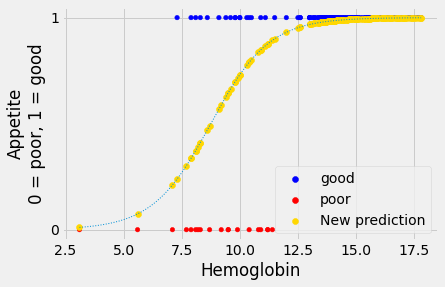

In [14]:
# Do the base plot of the hemoglobin and appetite_d.
plot_hgb_app()

# A new plot on top of the old.
plt.scatter(hemoglobin, predictions_new,
            label='New prediction',
            color='gold')
# Another plot, to show the underlying line
fine_y_sigmoid = params2pps(nice_c_s, fine_x)
plt.plot(fine_x, fine_y_sigmoid, linewidth=1, linestyle=':')
# Show the legend.
plt.legend();

This new not-straight line seems to have much to recommend it.  This shape of
line is called "sigmoid", from the name of the Greek letter "s".  The sigmoid
prediction here never goes above 1 or below 0, so its values are always in the
range of the `appetite_d` data it is trying to predict.  It climbs steeply to a
prediction of 1, and plateaus there, as we get to the threshold of about
hemoglobin of around 12.5, at which every patient does seem to have "good"
appetite (`appetite_d` of 1).

We can think of the values from the sigmoid curve as being *predicted
probabilities*.  For example, at a `hemoglobin` value of 10, the curve gives a
predicted y (`appetite_d`) value of about 0.73.  We can interpret this
prediction as saying that, with a hemoglobin value of 10, there is a
*probability* of about 0.73 that the corresponding patient will have a "good"
appetite (`appetite_d` value of 1).

Now let us say that we would prefer to use this kind of sigmoid line to predict
`appetite_d`.  So far, we have only asked `minimize` to predict directly from a
straight line - for example, in the `ss_any_line` function.   How can we get
minimize to predict from a family of sigmoid curves, as here?  Is there a way
of transforming a sigmoid curve like the one here, with y values from 0 to 1,
to a straight line, where the y values can vary “from large negative to large
positive.  We would like to do such a conversion, so we have a slope and
intercept that `minimize` can work with easily.

The answer, you can imagine, is "yes" - we can go from our sigmoid 0 / 1 curve
to a straight line with unconstrained y values, in two fairly simple steps.
The next sections will cover those steps.  The two steps are:

* Convert the 0 / 1 *probability* predictions to 0-to-large positive
  predictions of the *odds ratio*.  The odds-ratio can vary from 0 to very
  large positive.
* Apply the *logarithm* function to convert the 0-to-very-large-positive
  odds-ratio predictions to log odds-ratio predictions, which can vary from
  large negative to large positive.

These two transformations together are called the *log-odds* or
[logit](https://en.wikipedia.org/wiki/Logit) transformation.  *Logistical
regression* is regression using the *logit* transform.  Applying the logit
transform converts the sigmoid curve to a straight line.

We will explain more about the two stages of the transform below, but for now, here are the two stages in action.

This is the original sigmoid curve above, with the predictions, in its own
plot.

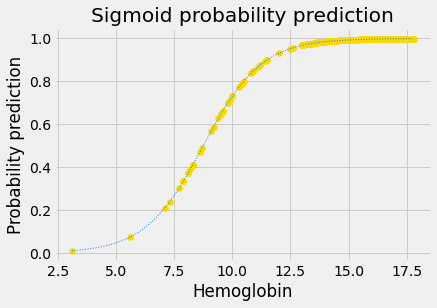

In [15]:
plt.scatter(hemoglobin, predictions_new,
            color='gold')
plt.plot(fine_x, fine_y_sigmoid, linewidth=1, linestyle=':')
plt.title('Sigmoid probability prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('Probability prediction');

Next we apply the conversion from probability to odds-ratio:

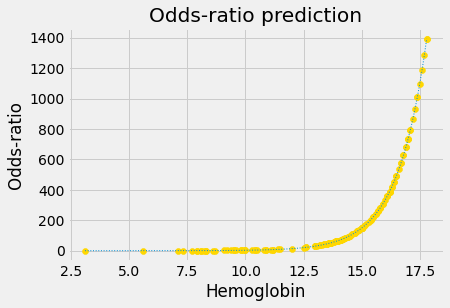

In [16]:
predictions_or = predictions_new / (1 - predictions_new)
plt.scatter(hemoglobin, predictions_or,
            color='gold')
fine_y_or = fine_y_sigmoid / (1 - fine_y_sigmoid)
plt.plot(fine_x, fine_y_or, linewidth=1, linestyle=':')
plt.title('Odds-ratio prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('Odds-ratio');

Notice that this is an exponential line.  We can turn exponential lines like this one into straight lines, using the *logarithm* function, the next stage of the logit transformation:

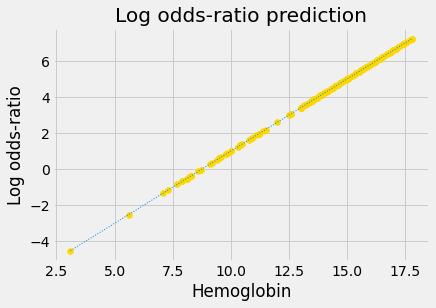

In [17]:
predictions_or_log = np.log(predictions_or)
plt.scatter(hemoglobin, predictions_or_log,
            color='gold')
fine_y_or_log = np.log(fine_y_or)
plt.plot(fine_x, fine_y_or_log, linewidth=1, linestyle=':')
plt.title('Log odds-ratio prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('Log odds-ratio');

Now we have a straight line, with an intercept and slope, suitable for
`minimize`.  The next few sections go into more detail on the odds-ratio and
logarithm steps.

## Probability and Odds

For logistic regression, in contrast to linear regression, we are interested in
predicting the *probability of an observation falling into a particular outcome
class* (0 or 1).

In this case, we are interested in the probability of a patient having "good"
appetite, predicted from the patient's hemoglobin.

From the graph above, it looks as those there is a higher probability of having
good appetite if you have a higher hemoglobin . We can see this because a
higher proportion of the blue dots (representing patients with good appetite)
occur at higher values of hemoglobin.

You'll know that probability is:

$$ \frac{\text{number of events of interest}}{\text{total number of events}} $$
<!-- #endregion -->

If we want to know how many people have anemia out of a group of 100 people, the probability of having anemia is:

$$ \frac{\text{number of people with anemia}}{\text{total number of people}} $$

So if there are 100 people, and 30 of them have anemia, the probability of having anemia (in that group) is:

$$ \frac{\text{number of people with anemia}}{\text{total number of people}} = \frac{\text{30}}{\text{100}}  $$

The odds of an event is a related, but different, concept. The odds are:

$$ \frac{\text{number of events of interest}}{\text{number of events NOT of interest}} $$

If we want to know how many people have anemia out of 100 people, the odds are:

$$ \frac{\text{number of people WITH anemia}}{\text{number of people who WITHOUT anemia}} $$

So if there are 100 people, and 30 of them have anemia, the odds of having anemia (in that group) are:
    
$$ \frac{\text{number of people WITH anemia}}{\text{number of people WITHOUT anemia}} = \frac{\text{30}}{\text{70}}  $$

# The Logistic Transformation

What we need is some mathematical wizardry that will allow us to use the linear regression formula, but to only generate predicted values that fall between 0 and 1. This prediction should represent the probability, based on the predictor variable, of being in the outcome class we dummy coded as 1.

It turns out there is a way to do this. Though bizarre it may sound, we will need the number `e` (https://en.wikipedia.org/wiki/E_(mathematical_constant).

This number is represented in numpy, and can be called using the command below.
<!-- #endregion -->

In [18]:
np.e

2.718281828459045

We can use the linear regression formula, along with `e`, to predict the odds of being anemic. The formula is below - let's focus on <i> how the formula works </i> rather than <i> why </i> the formula works .
    
$$ \text{predicted odds of anemia} = e^{\text{intercept + slope * Red Blood Cell Count}} $$

OK, so far so good, we raise `e` to the power of our linear regression predictions and we get a prediction of the odds of anemia for each observation. But there is still a problem - these odds are not limited to fall between 0 and 1:

In [19]:
odds_anemia = np.e**predicted_lin_reg

odds_anemia

0      2.024880
1      1.797553
2      1.968931
3      1.367842
4      1.584609
         ...   
153    2.775226
154    2.935188
155    2.794734
156    2.498419
157    2.794734
Name: Hemoglobin, Length: 158, dtype: float64

Fortunately, through some further mathematical wizardry, we can convert these odds to probabilities (which do fall between 0 and 1). The formula for doing this is below. 

Again, let's focus on what the formula does and how it works, rather than why it works:

$$ \text{predicted probability of anemia} = \frac{e^{\text{intercept + slope * Red Blood Cell Count}}}{1 + e^{\text{intercept + slope * Red Blood Cell Count}}}  $$

Let's use that formula to get the predicted probabilities.

In [20]:
prob_anemia = odds_anemia/(1 + odds_anemia)

prob_anemia

0      0.669408
1      0.642545
2      0.663178
3      0.577674
4      0.613094
         ...   
153    0.735115
154    0.745883
155    0.736477
156    0.714157
157    0.736477
Name: Hemoglobin, Length: 158, dtype: float64

Let's just check the predicted probabilities do all, in fact, fall between 0 and 1:

In [21]:
print('There are', np.count_nonzero(prob_anemia < 0), 'predicted probabilities less than 0.')  
print('There are', np.count_nonzero(prob_anemia > 1), 'predicted probabilities greater than 1.')  

There are 0 predicted probabilities less than 0.
There are 0 predicted probabilities greater than 1.


Let's plot these predicted probabilities along with the actual data:

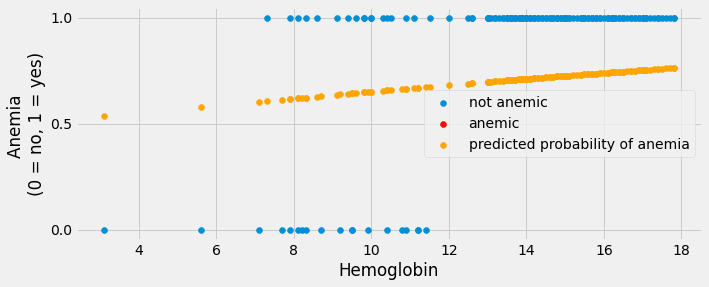

In [22]:
# do not worry about this code, it just generates the graph
plt.figure(figsize = (10, 4))
plt.scatter(hgb_app['Hemoglobin'], hgb_app['appetite_dummy'], label = 'not anemic')
plt.scatter(hgb_app[hgb_app['Appetite'] == 'yes']['Hemoglobin'], 
                             hgb_app[hgb_app['Appetite'] == 'yes']['appetite_dummy'], color = 'red',
            label = 'anemic')
plt.scatter(hgb_app['Hemoglobin'], prob_anemia, 
            label = 'predicted probability of anemia', color = 'orange')
plt.xlabel('Hemoglobin')
plt.ylabel('Anemia \n(0 = no, 1 = yes)')
plt.legend()
plt.yticks([0,0.5, 1]);

That looks better, the predicted probabilities all fall between 0 and 1. And the predictions still capture the general trend that the probability of having anemia is higher at lower values of Red Blood Cell Count.

However, to get these probabilities we used the slope and intercept we obtained from linear regression i.e. from minimizing the sum of squared prediction errors.

Using the sum of squared prediction error as the function we minimize is <b> not a good idea when we are trying to predict probabilities. </b>

To work well, `minimize` needs to work on a function which is <i> convex </i>. This is best illustrated graphically.

On the graphs below, the sum of squared prediction error is shown on the y axis. The potential values of the slope we may include in our model are shown on the x axis.

The graph for linear regression is shown on the left; the graph for logistic regression is shown on the right.

For normal linear regression - i.e. without using `e` to do the transformations we just did - there is a single lowest point on the graph which shows the relationship between the slope value (x axis) and the sum of squared prediction error (y axis). 

This lowest point occurs for the best fitting slope. `minimize` can easily find this point, because it is the lowest point out of all the possible slopes we could use.


Conversely, when we use `e` to apply the transformations above (in order to predict probabilities), the graph for the sum of squared prediction errors looks like the graph on the right hand side below. 

`minimize` can easily get 'stuck' in one of the other low points, which is not the lowest possible point. This means we may get estimates of the slope and intercept which do not give the lowest possible sum of the squared prediction error.

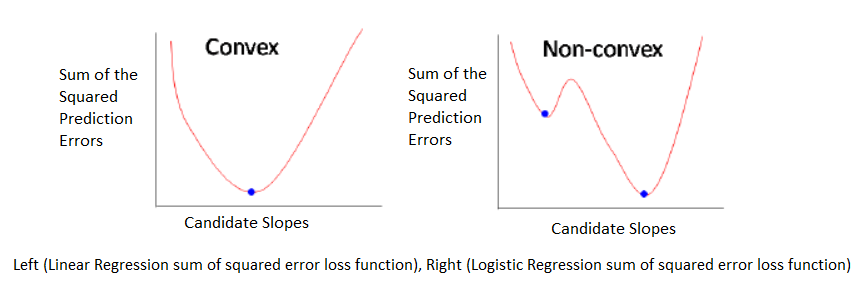

(image adapted from: 
https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d)

## A different measure of prediction error

To address this issue, logistic regression does not minimize the sum of the squared prediction errors like linear regression does. 

Logistic regression uses a different function for calculating prediction errors, and it minimizes this function instead. Another way of saying this is that it minimizes a different cost function.

The cost function that logistic regression uses is convex - meaning it works much better with minimize, as it has a single lowest point.

To understand the function logistic regression uses to calculate prediction errors, we will need to do a very brief aside about <i> natural logarithms </i>.

#### Natural Logarithms

The natural logarithm of a number tells you: "what power would I have to raise `e` to, in order to produce this number?".

This sounds more complex than it is. 

`e` squared equals 7.3890560989306495, as we can see from the cell below:

In [23]:
np.e**2

7.3890560989306495

If I asked you, now you've seen the cell above: "what number would I have to raise `e` to, in order to get 7.3890560989306495?".

If you're really good at remembering decimal places, you'd say: "well, `e` squared equals 7.3890560989306495. So you raise `e` to the power of 2 to get 7.3890560989306495".

Another way of saying this is that the natural log of 7.3890560989306495 is 2. 

We can represent this with a formula:

$$ ln(7.3890560989306495) = 2 $$

`ln(7.3890560989306495)` means 'the natural log of 7.3890560989306495'. We can use `np.log()` to calculate the natural logarithm of a number.

In [24]:
np.log(7.3890560989306495)

2.0

In logistic regression, we calculate the prediction errors are follows:

If the dummy variable of the actual outcome score equals 1, then the prediction error equals the negative natural logarithm of the predicted probability:

 $$ \text{if the actual outcome == 1, then:}$$
 $$\text{prediction error = -ln(predicted probability)} $$

If the dummy variable of the actual outcome score equals 0, then the prediction error equals the negative natural logarithm of 1 minus the predicted probability.

 $$ \text{if the actual outcome == 0, then:}$$
 $$\text{prediction error = -ln(1 - predicted probability)} $$

Again, this looks more complex than it is (I promise!). Once more, it is better to focus on how this calculation works, rather than why it works.

The table below shows some possible pairings of the actual outcome and predicted outcome. The predicted outcome is a probability, it is the predicted probability that an observations falls into the class with the dummy variable 1:

In [25]:
# this is just here to generate the illustration

illustration = pd.DataFrame({'actual outcome': [0, 1, 0, 1], 'predicted probability of being in class 1': [0.2, 0.8, 0.8,0.2],
                           'prediction close?': ['yes', 'yes', 'no', 'no']})

illustration

,actual outcome,predicted probability of being in class 1,prediction close?
0,0,0.2,yes
1,1,0.8,yes
2,0,0.8,no
3,1,0.2,no


Let's write a python function to calculate the prediction errors for logistic regression. 

This is called a <i> piecewise function, </i> because what the function does varies depending on what input it is given. In python, we can do this with `if` statements:

In [26]:
def log_reg_pred_err(actual_outcome, predicted_probability):
    
    # create an array to store the prediction errors
    prediction_error = np.zeros(len(actual_outcome))
    
    # for every observation
    for i in np.arange(len(actual_outcome)):
        
        # if the actual outcome for that observation is in class 1...
        if actual_outcome[i] == 1:
            
            # ...then the prediction error equals the negative natural logarithm of the predicted probability
            prediction_error[i] = -np.log(predicted_probability[i])
            
        # if the actual outcome for that observation is in class 0...
        if actual_outcome[i] == 0:
            
            # ...then prediction error equals the negative natural logarithm of 1 minus the predicted probability
            prediction_error[i] = -np.log(1 - predicted_probability[i])
        
    return prediction_error

Let's calculate the prediction errors for the values in the dataframe above:

In [27]:
illustration['prediction error'] = log_reg_pred_err(illustration['actual outcome'], 
                                                    illustration['predicted probability of being in class 1'])

illustration

,actual outcome,predicted probability of being in class 1,prediction close?,prediction error
0,0,0.2,yes,0.223144
1,1,0.8,yes,0.223144
2,0,0.8,no,1.609438
3,1,0.2,no,1.609438


Make sure you inspect this dataframe in great detail. It is very important. Remember that the predicted probability is is the probability of being in class 1. 

We want the predicted probability to be large (close to 1) when the actual outcome score is in class 1. We want the predicted probability to be small (close to 0) when the actual outcome score is in class 0.

<b> You can see that when the prediction is close - i.e. when the predicted probability is accurate - the prediction error is small. </b>

<b> When the prediction is not close, the prediction error is large. </b>

Remember that good model leads to <i> small prediction errors </i>. 

Even if you do not understand the precise mechanics of the prediction error formulas in logistic regression, you can see how they work. 

<i> When the predictions are good, the error values are small. When the predictions are bad, the error values are large. </i>

Let's illustrate this further with a graph. The graph below shows the prediction error function for logistic regression:

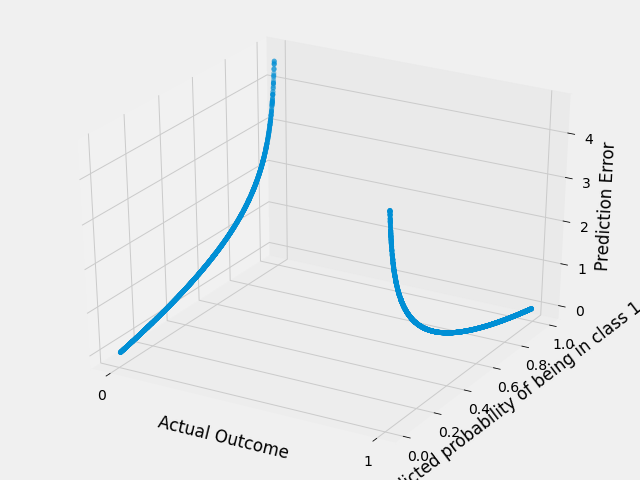

In [28]:
# do not worry about this code, it just generates the graph

actual = np.random.choice([0,1], size = 5000)

predictions = np.random.uniform(0.01, 0.99, size = 5000)

error = log_reg_pred_err(actual, predictions)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(actual, predictions, error)
plt.xlabel('Actual Outcome')
plt.xticks([0,1])
plt.ylabel('Predicted probability of being in class 1')

ax.set_zlabel('Prediction Error');
plt.show()

Again, take a bit of time to go over this graph. It is very important for understanding logistic regression.

You can see from the graph that:

If the actual outcome class is 0, and the predicted probability is close to 0, the prediction error is low.

If the actual outcome class is 0, and the predicted probability is close to 1, the prediction error is high.

If the actual outcome class is 1, and the predicted probability is close to 0, the prediction error is high.

If the actual outcome class is 1, and the predicted probability is close to 1, the prediction error is low.

Keep re-visiting the graph until you are sure of this pattern.

## What is the name of the function for calculating prediction errors in logistic regression?

The function we have just used for calculating the prediction errors in logistic regression is called the <i> cross-entropy cost function. </i>

Conversely the errors in linear regression are calculated using the <i> squared prediction error function </i>.

Both of these are shown again below, just so you can see how different they are:

### Logistic regression cross-entropy cost function:

 $$ \text{if the actual outcome == 1, then:}$$
 $$\text{prediction error = -ln(predicted probability)} $$

 $$ \text{if the actual outcome == 0, then:}$$
 $$\text{prediction error = -ln(1 - predicted probability)} $$
 
### Linear regression squared prediction error function:

$$ \text{squared prediction error = (actual outcome value - predicted outcome value)}^2 $$



## What do the slope and intercept mean for logit

Changing the intercept of the logit straight line moves the corresponding
sigmoid curve left and right on the horizontal axis:

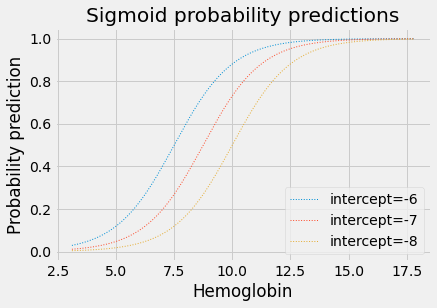

In [29]:
for intercept in [-6, -7, -8]:
    plt.plot(fine_x,
            params2pps([intercept, 0.8], fine_x),
            linewidth=1,
            linestyle=':',
            label=f'intercept={intercept}')
plt.title('Sigmoid probability predictions')
plt.xlabel('Hemoglobin')
plt.ylabel('Probability prediction')
plt.legend();

Changing the slope of the logit straight line makes the transition from 0 to 1
flatter or steeper:

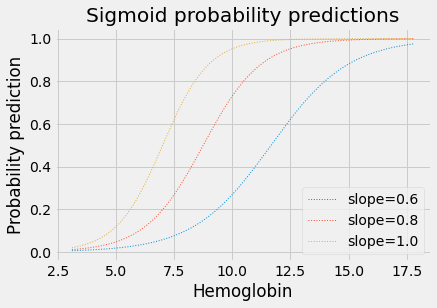

In [30]:
for slope in [0.6, 0.8, 1.0]:
    plt.plot(fine_x,
            params2pps([-7, slope], fine_x),
            linewidth=1,
            linestyle=':',
            label=f'slope={slope:.1f}')
plt.title('Sigmoid probability predictions')
plt.xlabel('Hemoglobin')
plt.ylabel('Probability prediction')
plt.legend();

# Logistic Regression using minimize

We now have the tools we need to implement logistic regression using minimize. We are going to predict Anemia status (yes/no) from Red Blood Cell Count.

The actual function that we minimize in logistic regression is the <i> average prediction error, </i> where each prediction error is calculated using the cross-entropy function shown above.

Let's write a function to pass to `minimize`, which calculates the average prediction error for an intercept and slope pair. Go over the comments in the cell below and make sure you understand what each line is doing.

In [31]:
def logb(arr, b=np.e):
    """ Logarithm of `arr` to base `b`
   
    From formula in:
    
    https://en.wikipedia.org/wiki/Logarithm#Change_of_base
    """
    return np.log(arr) / np.log(b)

In [32]:
print(logb(11), np.log(11))
print(logb(11, b=10), np.log10(11))
print(logb(11, b=2), np.log2(11))

2.3978952727983707 2.3978952727983707
1.041392685158225 1.0413926851582251
3.4594316186372978 3.4594316186372973


In [33]:
def params2pps(intercept_and_slope, x, b=np.e):
    """ Calculate predicted probabilities of 1 for each observation
    """
    # store the intercept and slope as Python variables.
    intercept, slope = intercept_and_slope
    # Predicted log odds of being in class 1.
    predicted_log_odds = intercept + slope * x
    # To get the odds, we invert the log operation.
    predicted_odds = b ** predicted_log_odds
    # Predicted probability of being in class 1.
    return predicted_odds / (1 + predicted_odds)

In [34]:
def p_y_given_pps(pps, y):
    # pps is the predicted probability of being in class 1.
    # Because class 1 and 0 are mutually exclusive:
    pp0 = 1 - pps
    p_of_y = pps.copy()  # y == 1 values correctly set.
    p_of_y[y == 0] = pp0[y == 0]  # set the y==0 values.
    # Or - equivalently, but rather less readably:
    # p_of_y = y * pp1 + (1 - y) * pp0
    return p_of_y

In [35]:
def calc_log_likelihood(pp1, y, b=np.e):
    """ Overall log likelihood of `y` given predicted ps `pp1`
    """
    p_of_ys = p_y_given_pps(pp1, y)
    # Overall likelihood of this intercept, slope combination is the product of
    # all the likelihoods (we are multiplying probabilities).
    # That would be:
    # likelihood = np.prod(likelihoods)
    # But - if we just multiply these, there are often so many values close to
    # zero that the result gets close to the smallest values the computer can
    # represent or even gets smaller, in which case the value becomes 0.
    # To avoid this, we can add the logs (instead of taking the product of the
    # original values).  Adding the logs gives us the log of the likelihood as
    # defined above.
    # Which base we use for the log here does not matter, we're just
    # trying to maintain the precision, the results will go up and down
    # in the same way, for the same values, and we don't care about
    # the exact number, only that it is higher for a higher likelihood.
    # But - just for completeness, use the general log function.
    log_likelihood = np.sum(logb(p_of_ys, b=b))
    return log_likelihood

In [36]:
def log_reg_cost(intercept_and_slope, x, y, b=np.e):
    # Predicted probability of being in class 1.
    pp1 = params2pps(intercept_and_slope, x, b=b)
    # Overall log of the likelihood of observed outomes y
    log_likelihood = calc_log_likelihood(pp1, y, b=b)
    # At the moment, a higher value here means the intercept and slope are a
    # *better* fit, but minimize wants the value to go *down* for a better fit,
    # so we just stick a minus on it to make better fits give lower values.
    return -log_likelihood

In [37]:
from scipy.optimize import minimize

predictor = hgb_app['Hemoglobin']
outcome = hgb_app['appetite_dummy']

# Results using default base of np.e
b_e_res = minimize(log_reg_cost, [1,1], args = (predictor,outcome))
p_values_e = params2pps(b_e_res.x, predictor)
print('Base e fun value, best-fit parameters:', b_e_res.fun, b_e_res.x)
# Results using base 10
b_10_res = minimize(log_reg_cost, [1,1], args = (predictor, outcome, 10))
p_values_10 = params2pps(b_10_res.x, predictor, b=10)
print('Base 10 fun value, best-fit parameters:', b_10_res.fun, b_10_res.x)
# The fun value, parameters for log e, log 10 are predictably scaled
# versions of each other.
print('Base 10 fun value, parameters, scaled by log(10):',
      b_10_res.fun * np.log(10), b_10_res.x * np.log(10))
# The estimated p values are (more or less) the same.
print('p likelihoods similar?', np.allclose(p_values_e, p_values_10))

Base e fun value, best-fit parameters: 29.16799389585646 [-7.29187391  0.79915454]
Base 10 fun value, best-fit parameters: 12.667498797159672 [-3.16681915  0.34706827]
Base 10 fun value, parameters, scaled by log(10): 29.16799389585987 [-7.29187056  0.79915422]
p likelihoods similar? True


In [38]:
# Review what happens with the likelihood.
pp1 = params2pps(b_e_res.x, predictor)
p_of_ys = p_y_given_pps(pp1, outcome)
p_of_ys

0      0.159942
1      0.425534
2      0.207675
3      0.943567
4      0.757383
         ...   
153    0.994805
154    0.997252
155    0.995202
156    0.982979
157    0.995202
Name: Hemoglobin, Length: 158, dtype: float64

In [39]:
# We would be sort-of OK with the best parameters, in that
# the product of the p values is not that close to 0:
likelihood = np.prod(p_of_ys)
print(likelihood)
log_likelihood = np.sum(np.log(p_of_ys))
print(log_likelihood)
print(np.e ** log_likelihood)

2.150310634930424e-13
-29.16799389585646
2.1503106349304338e-13


In [40]:
# But it's a mess if we are further off, so some of the p
# values get very small, and the product of the p values gets
# very close to 0 - and then so close that it becomes 0.
pp1_bad = params2pps([12, -1], predictor)
p_of_ys_bad = p_y_given_pps(pp1_bad, outcome)
p_of_ys_bad

0      0.310026
1      0.075858
2      0.231475
3      0.001659
4      0.013387
         ...   
153    0.024127
154    0.010987
155    0.021881
156    0.099750
157    0.021881
Name: Hemoglobin, Length: 158, dtype: float64

In [41]:
likelihood_bad = np.prod(p_of_ys_bad)
print(likelihood_bad)
log_likelihood_bad = np.sum(np.log(p_of_ys_bad))
print(log_likelihood_bad)
print(np.e ** log_likelihood_bad)

5.973154301684103e-194
-444.91423289423165
5.973154301684148e-194


In [42]:
# We could fix this with numbers that have 50 digits of precision
# but that would be horribly slow.
from decimal import Decimal, getcontext
getcontext().prec = 50  # 50 decimal points.
# An array of numbers working with 50 decimal digits of precision.
p_of_ys_bad_hp = p_of_ys_bad.apply(Decimal)
likelihood_bad_hp = np.prod(p_of_ys_bad_hp)
print(likelihood_bad_hp)
logs_hp = p_of_ys_bad_hp.apply(Decimal.ln)
log_likelihood_bad_hp = np.sum(logs_hp)
print(log_likelihood_bad_hp)
e_hp = Decimal(1).exp()  # e to 50 decimal places.
print(e_hp ** log_likelihood_bad_hp)

5.9731543016841026370435694158284851613355032167866E-194
-444.91423289423162929913986182208901652671868340786
5.9731543016841026370435694158284851613355032167541E-194


Notice above that the log likelihood is near as dammit the same as when we do the calculation without the high-precision numbers, but the high-precision numbers stop the rounding to 0.

The conclusion is - we can keep using the log-likelihood at our usual fast precision, but we do need to do the log-likelihood rather than the direct product of p values, to avoid the calculation breaking down when it's trying parameters that are fairly far off.

Now let's pass our function to `minimize`, to find the slope and intercept which minimize the average prediction error.

We'll start with an intercept of 1 and a slope of 1 as our first guess. 

In [43]:
# store the predictor variable as a python variable
predictor = hgb_app['Hemoglobin']

# store the dummy-coded outcome variable as a python variable 
outcome = hgb_app['appetite_dummy']

min_log_reg = minimize(log_reg_cost, [1,1], args = (predictor,outcome))
min_log_reg 

      fun: 29.16799389585646
 hess_inv: array([[ 0.36272479, -0.04141136],
       [-0.04141136,  0.00593735]])
      jac: array([-2.38418579e-07,  3.09944153e-06])
  message: 'Optimization terminated successfully.'
     nfev: 66
      nit: 14
     njev: 22
   status: 0
  success: True
        x: array([-7.29187391,  0.79915454])

So `minimize` found an intercept of 10.43827715 and a slope of -3.14932093. These values minimize the prediction errors, calculated using the cross-entropy function.

The slope is more interesting than the intercept here. 

In fact the intercept is quite hard to interpret (for those who are interested: it is is the predicted natural logarithm of the odds of being in outcome class 1, for an observation with a Red Blood Cell Count of 0).

The precise value of the slope is also quite hard to interpret, because it also relates to the natural logarithm of the odds of being in outcome class 1. 

However, because the slope is negative, this tells us that as Red Blood Cell Count increases, the odds of being in class 1 (having anemia) decrease.

Interpreting logistic regression is much easier if we use this slope and intercept to generate predicted probabilities of having anemia, for each observation.

As we did before, let's generate the predicted probabilities using the intercept/slope values that `minimize` has found. The formulas for doing this are shown once more here for convenience:

Calculate the predicted odds of having anemia:

$$ \text{predicted odds of anemia} = e^{\text{intercept + slope * Red Blood Cell Count}} $$

Calculate the predicted probability of having anemia:

$$ \text{predicted probability of anemia} = \frac{e^{\text{intercept + slope * Red Blood Cell Count}}}{1 + e^{\text{intercept + slope * Red Blood Cell Count}}} = \frac{e^{\text{odds of anemia}}}{1 + e^{\text{odds of anemia}}} $$

<i> Remember: </i> there is one predicted probability for each observation. This predicts the probability of having anemia for that patient, based on the patient's score on the Red Blood Cell Count variable.

In [44]:
# store the intercept as a python variable
log_reg_intercept = min_log_reg.x[0]

# store the slope as a python variable
log_reg_slope = min_log_reg.x[1]

# generate the predicted odds of having anemia (using the tricks from above)
predicted_odds_log_reg = np.e**(log_reg_intercept + log_reg_slope * hgb_app['Hemoglobin'])

# generate the predicted probability of having anemia (using the tricks from above)
predicted_probs_log_reg = predicted_odds_log_reg/(1 + predicted_odds_log_reg)

predicted_probs_log_reg

0      0.840058
1      0.574466
2      0.792325
3      0.056433
4      0.242617
         ...   
153    0.994805
154    0.997252
155    0.995202
156    0.982979
157    0.995202
Name: Hemoglobin, Length: 158, dtype: float64

Let's plot the predictions against the actual data:

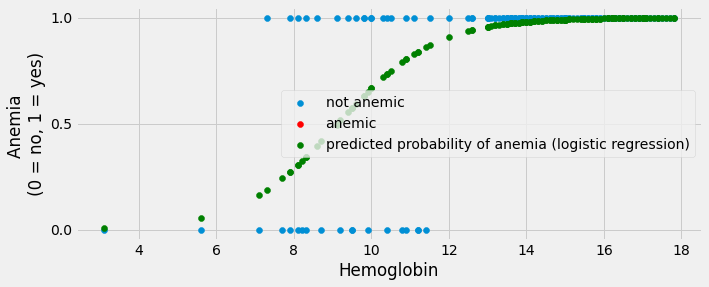

In [45]:
# do not worry about this code, it just generates the graph
plt.figure(figsize = (10, 4))
plt.scatter(hgb_app['Hemoglobin'], hgb_app['appetite_dummy'], label = 'not anemic')
plt.scatter(hgb_app[hgb_app['Appetite'] == 'yes']['Hemoglobin'], 
                             hgb_app[hgb_app['Appetite'] == 'yes']['appetite_dummy'], color = 'red',
            label = 'anemic')
plt.scatter(hgb_app['Hemoglobin'], predicted_probs_log_reg, 
            label = 'predicted probability of anemia (logistic regression)', color = 'green')
plt.xlabel('Hemoglobin')
plt.ylabel('Anemia \n(0 = no, 1 = yes)')
plt.legend()
plt.yticks([0,0.5, 1]);

Just for comparison, let's also show the predictions we got when we predicted the probabilities using the slope and intercept that we got from linear regression:

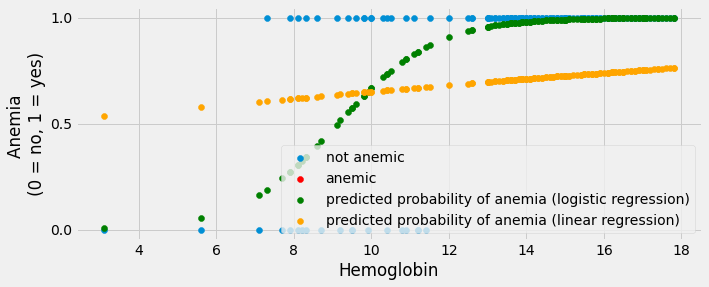

In [46]:
# do not worry about this code, it just generates the graph
plt.figure(figsize = (10, 4))
plt.scatter(hgb_app['Hemoglobin'], hgb_app['appetite_dummy'], label = 'not anemic')
plt.scatter(hgb_app[hgb_app['Appetite'] == 'yes']['Hemoglobin'], 
                             hgb_app[hgb_app['Appetite'] == 'yes']['appetite_dummy'], color = 'red',
            label = 'anemic')
plt.scatter(hgb_app['Hemoglobin'], predicted_probs_log_reg, 
            label = 'predicted probability of anemia (logistic regression)', color = 'green')
plt.scatter(hgb_app['Hemoglobin'], prob_anemia, 
            label = 'predicted probability of anemia (linear regression)', color = 'orange')
plt.xlabel('Hemoglobin')
plt.ylabel('Anemia \n(0 = no, 1 = yes)')
plt.legend()
plt.yticks([0,0.5, 1]);

We can see that logistic regression fits the data much better.

With logistic regression, the predicted probability of having anemia falls steeply as the Red Blood Cell Count increases.

The predicted probabilities from linear regression overestimate the probability of anemia at higher values of Red Blood Cell Count.

You can see that the predictions from logistic regression form an 'S' shape. This is a nonlinear function called a <i> sigmoid function. </i>

Linear regression fits a <i> line to directly predict outcome scores, based on scores on a predictor variable.</i>

Logistic regression fits a <i> sigmoid function to predict the probability of being in one of two categories, based on scores on a predictor variable </i>.

## Logistic Regression with statsmodels

As with linear regression, we can easily perform logistic regression using statsmodels.

To do this, we first have to add a column of 1's to the predictor variable. This is to ensure the intercept is fitted correctly, though we will not explore why - just remember to do it in order to get better estimates! We can use the statsmodels function `add_constant()` to do this:

<i> Note: here we are using `statsmodels.api` rather than `statsmodels.formula.api` </i> 

In [47]:
list(df)

['Age',
 'Blood Pressure',
 'Specific Gravity',
 'Albumin',
 'Sugar',
 'Red Blood Cells',
 'Pus Cell',
 'Pus Cell clumps',
 'Bacteria',
 'Blood Glucose Random',
 'Blood Urea',
 'Serum Creatinine',
 'Sodium',
 'Potassium',
 'Hemoglobin',
 'Packed Cell Volume',
 'White Blood Cell Count',
 'Red Blood Cell Count',
 'Hypertension',
 'Diabetes Mellitus',
 'Coronary Artery Disease',
 'Appetite',
 'Pedal Edema',
 'Anemia',
 'Class']

In [48]:
import statsmodels.formula.api as smf

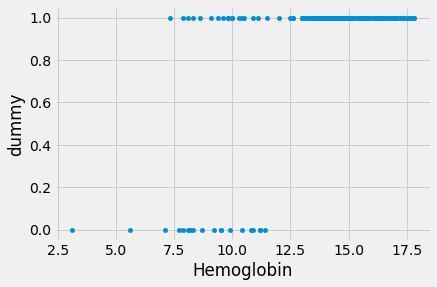

In [49]:
# Creating the model
op_col = 'Appetite'
val_1 = 'good'
ip_col = 'Hemoglobin'
ip_df = df.loc[:, [op_col, ip_col]]
ip_df['dummy'] = (ip_df[op_col] == val_1).astype(int)
ip_df.plot.scatter(ip_col, 'dummy')

In [50]:
col_is_obj = df.dtypes == object
category_cols = df.columns[col_is_obj]
num_cols = df.columns[~col_is_obj]
nums = df.replace({'yes': 1, 'no': 0,
                   'abnormal': 1, 'normal': 0,
                   'present': 1, 'notpresent': 0,
                   'good': 1, 'poor': 0
                  }).astype(np.float)
nums.corr().loc[category_cols, num_cols]

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Blood Glucose Random,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Class
Red Blood Cells,0.147971,0.316670,-0.500494,0.489941,0.256568,0.493857,0.378478,0.410408,-0.344916,-0.019319,-0.452566,-0.422537,0.108857,-0.379378,0.586391
Pus Cell,0.188907,0.179834,-0.630323,0.752956,0.335901,0.430646,0.613318,0.588517,-0.520324,0.176150,-0.733140,-0.718042,0.169936,-0.667113,0.775388
Pus Cell clumps,0.124032,0.206507,-0.460050,0.503341,0.177327,0.257768,0.366726,0.361965,-0.473954,-0.030297,-0.531182,-0.534564,0.146742,-0.499401,0.509915
Bacteria,0.068353,0.174555,-0.516392,0.516104,0.381929,0.318095,0.205351,0.229238,-0.221374,-0.000279,-0.410353,-0.397500,0.170071,-0.343299,0.468845
Hypertension,0.372348,0.334951,-0.648168,0.796876,0.577286,0.579407,0.623738,0.659078,-0.529828,0.183336,-0.746016,-0.752043,0.223916,-0.671740,0.856334
Diabetes Mellitus,0.323957,0.218096,-0.639391,0.678582,0.591010,0.663012,0.565137,0.567390,-0.472327,0.188797,-0.658510,-0.655039,0.287010,-0.594881,0.758965
Coronary Artery Disease,0.269868,0.257709,-0.379305,0.374755,0.466658,0.459164,0.312485,0.321205,-0.217612,0.007149,-0.378777,-0.375627,0.021259,-0.362439,0.447355
Appetite,-0.170259,-0.145047,0.523944,-0.578080,-0.220547,-0.338924,-0.502091,-0.510699,0.485093,-0.000014,0.618762,0.629102,-0.328730,0.556182,-0.604622
Pedal Edema,0.232327,0.117878,-0.633622,0.622268,0.374128,0.336141,0.581566,0.623109,-0.466484,0.008052,-0.596579,-0.606829,0.282628,-0.566384,0.622573
Anemia,0.105809,0.311097,-0.413252,0.569529,0.179811,0.139854,0.654444,0.663212,-0.563627,0.248296,-0.640379,-0.655724,0.139224,-0.581576,0.548947


In [51]:
log_reg_mod = smf.logit('dummy ~ Q("{}")'.format(ip_col),
                        data=ip_df)

fitted_log_reg_mod = log_reg_mod.fit() # fitting the model

fitted_log_reg_mod.summary() # showing the model summary

Optimization terminated successfully.
         Current function value: 0.184608
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  dummy   No. Observations:                  158
Model:                          Logit   Df Residuals:                      156
Method:                           MLE   Df Model:                            1
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:                  0.4976
Time:                        15:04:09   Log-Likelihood:                -29.168
converged:                       True   LL-Null:                       -58.054
Covariance Type:            nonrobust   LLR p-value:                 2.944e-14
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -7.2919      1.659     -4.396      0.000     -10.543      -4.041
Q("Hemoglobin")     0.7992      0.158      5.042      0.000       0.489       1.110
===================================================================================
"""

Look at the table above under 'coef'. Compare the logistic regression intercept and slope that statsmodels has obtained to the ones we obtained through using `minimize`:

In [52]:
print('Intercept from minimize =', log_reg_intercept)
print('Slope from minimize =', log_reg_slope)

Intercept from minimize = -7.29187391187747
Slope from minimize = 0.799154540146446


Finally, we can use the `predict` method of statsmodels to generate predicted
probabilities from the logistic regression model we just fitted:

In [53]:
sm_predictions = fitted_log_reg_mod.predict(ip_df[ip_col])
sm_predictions

0      0.840058
1      0.574466
2      0.792325
3      0.056433
4      0.242617
         ...   
153    0.994805
154    0.997252
155    0.995202
156    0.982979
157    0.995202
Length: 158, dtype: float64

Let's plot the predicted probabilities of having anemia, from statsmodels:

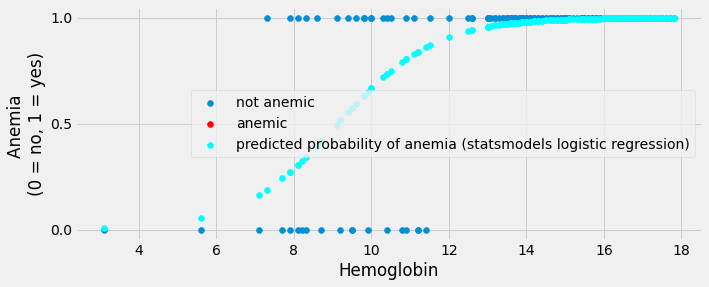

In [54]:
# do not worry about this code, it just generates the graph
plt.figure(figsize = (10, 4))
plt.scatter(hgb_app['Hemoglobin'], hgb_app['appetite_dummy'], label = 'not anemic')
plt.scatter(hgb_app[hgb_app['Appetite'] == 'yes']['Hemoglobin'], 
                             hgb_app[hgb_app['Appetite'] == 'yes']['appetite_dummy'], color = 'red',
            label = 'anemic')
plt.scatter(hgb_app['Hemoglobin'], sm_predictions,
            label = 'predicted probability of anemia (statsmodels logistic regression)', color = 'cyan')
plt.xlabel('Hemoglobin')
plt.ylabel('Anemia \n(0 = no, 1 = yes)')
plt.legend()
plt.yticks([0,0.5, 1]);

We can see graphically that these predictions look identical to the ones we obtained from minimize.

Let's see what the largest absolute difference between the predictions from the two methods is:

In [55]:
np.max(np.abs(predicted_probs_log_reg - sm_predictions))

4.643944356841345e-08

That is very close to 0. The models are making almost identical predictions.

## Summary

This tutorial has shown you how to do binary logistic regression with one numerical predictor variable.